In [ ]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design
from scipy.optimize import minimize
from sympy import *
import control
import time
import matplotlib.pyplot as plt
import ae353_spacecraft_simulate

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

In [145]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=None,
)

argv[0]=


In [146]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7024/static/


In [ ]:
wheels = [
    {'alpha': np.pi, 'delta': np.pi /6},
    {'alpha':  np.pi / 3, 'delta': np.pi/6},
    {'alpha': -np.pi /3 , 'delta': np.pi/6},
    {'alpha': 0, 'delta': -np.pi/2},
]
design.show_wheels(vis, wheels)

In [148]:
design.show_wheels(vis, wheels)

In [149]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}23.37 & 0.0 & 0.0\\0.0 & 23.37 & 0.0\\0.0 & 0.0 & 20.08\end{matrix}\right]$$

In [150]:
stars = [ 
    {'alpha':  0.00, 'delta':  0.00},
    {'alpha':  -0.10, 'delta':  -0.10},
    {'alpha':  0.10, 'delta':  -0.10}                              # <-- To add a star, append a copy of this dict to the list. To change
                                                    #     the location of a star, change the value of alpha and delta
]

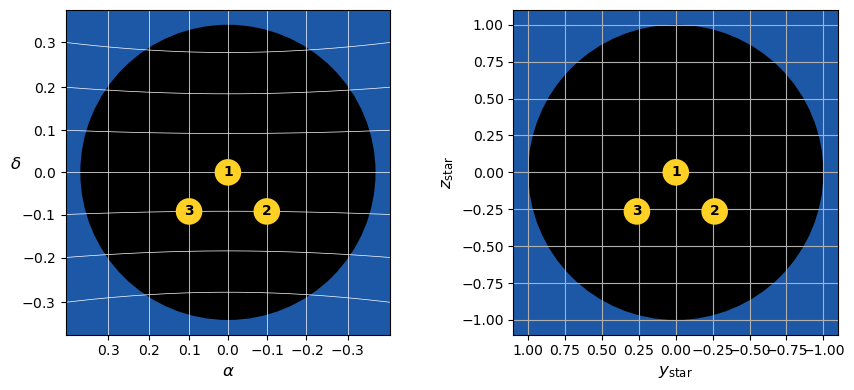

In [151]:
design.show_stars(stars)

In [152]:
design.create_stars(stars)

In [153]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

In [154]:
F_num = lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], [f])

f_num_for_minimize  = lambda x: np.linalg.norm(np.array( F_num(*x) ). flatten())**2

# Inital guess
x0 = [0. , # Guess at psi
      0. , # Guess at theta
      0. , # Guess at phi
      0. , # Guess at w_x
      0. , # Guess at w_y
      0. , # Guess at w_z
      0. , # Guess at tau_1
      0. , # Guess at tau_2
      0. , # Guess at tau_3
      0. ] # Guess at tau_4
      
sol = minimize(f_num_for_minimize, x0, tol=1e-6)# Find minimum

# Show solution
psi_e   = sol.x[0]
theta_e = sol.x[1]
phi_e   = sol.x[2]
w_xe    = sol.x[3]
w_ye    = sol.x[4]
w_ze    = sol.x[5]
tau_1e  = sol.x[6]
tau_2e  = sol.x[7]
tau_3e  = sol.x[8]
tau_4e  = sol.x[9]

#Taking the jacobian to construct A and B matrix
A_sym = f.jacobian([psi, theta, phi, w_x, w_y, w_z])
B_sym = f.jacobian([tau_1, tau_2, tau_3, tau_4])

#Defining lambda function to convert A, B from symbolic to numeric
A_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], A_sym)
B_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], B_sym)

A = A_num(psi_e, theta_e, phi_e, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e)
B = B_num(psi_e, theta_e, phi_e, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e)

n = A.shape[0]

W = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
l = np.linalg.matrix_rank(W)
l

print(l)



6


In [155]:
alpha, delta = sym.symbols('alpha, delta')

In [156]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

In [157]:
# Define alpha and delta symbols
alpha, delta = sym.symbols('alpha delta')

# Compute symbolic sensor model once
g = sym.simplify(p_star_in_image, full=True)

# Initialize list to hold g values
g_entries = []

# Loop through each star and substitute alpha, delta
for star in stars:
    g_star = g.subs({alpha: star['alpha'], delta: star['delta']})
    g_entries.extend(g_star)  # Flatten and append both components

# Create 6x1 column matrix
g_matrix = sym.Matrix(g_entries)

g_matrix


Matrix([
[                                                                                                                                                   21*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi))/(8*cos(psi)*cos(theta))],
[                                                                                                                                                   21*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))/(8*cos(psi)*cos(theta))],
[21*(0.995004165278026*sin(phi)*sin(theta)*cos(psi + 0.1) - 0.0998334166468282*sin(phi)*cos(theta) - 0.995004165278026*sin(psi + 0.1)*cos(phi))/(8*(0.0998334166468282*sin(theta) + 0.995004165278026*cos(theta)*cos(psi + 0.1)))],
[21*(0.995004165278026*sin(phi)*sin(psi + 0.1) + 0.995004165278026*sin(theta)*cos(phi)*cos(psi + 0.1) - 0.0998334166468282*cos(phi)*cos(theta))/(8*(0.0998334166468282*sin(theta) + 0.995004165278026*cos(theta)*cos(psi + 0.1)))],
[21*(0.995004165278026*sin(phi)*sin(theta)*cos(psi - 0.1) - 0.0998334166468282*

In [158]:
C_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4],g_matrix.jacobian([psi, theta, phi, w_x, w_y, w_z]))
D_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4],g_matrix.jacobian([tau_1, tau_2, tau_3, tau_4]))

C = C_num(psi_e, theta_e, phi_e, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e)
D = D_num(psi_e, theta_e, phi_e, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e)

In [159]:
sym.Matrix(C)
sym.Matrix(D)

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [160]:
n = A.shape[0]
Wo = C.T
for i in range(1, n):
    col = np.linalg.matrix_power(A.T, i) @ C.T
    Wo = np.block([Wo, col])
Wo = Wo.T
rank_o= np.linalg.matrix_rank(Wo)
rank_o

np.int64(6)

In [161]:
# Gain Matrix for A and B
Q = np.diag([1000.,1000.,1000.,100.,100.,100.])
R = np.diag([1., 1., 1., 1.])

K, _, _ = control.lqr(A, B, Q, R)
F_matrix = (A - B@K)
s = np.linalg.eigvals(F_matrix)
print("Gain Matrix:",K)
print("Eigenvalues:",s)

Gain Matrix: [[-11.95228609   0.          25.81988897  31.55273132   0.
  -12.30480867]
 [-11.95228609 -22.36067977 -12.90994449 -15.77636566 -27.32546688
  -12.30480867]
 [-11.95228609  22.36067977 -12.90994449 -15.77636566  27.32546688
  -12.30480867]
 [ 23.90457219  -0.           0.           0.          -0.
   24.60961735]]
Eigenvalues: [-1.07254815+0.96606497j -1.07254815-0.96606497j -0.87703826+0.81619898j
 -0.87703826-0.81619898j -0.87703826+0.81619898j -0.87703826-0.81619898j]


In [162]:
Qo = np.diag([1., 1. ,1.,1.,1.,1.])
Ro = np.diag([1.,1.,1.,1.,1.,1.])

l, _, _ = control.lqr(A.T, C.T, np.linalg.inv(Qo), np.linalg.inv(Ro))
L = l.T
O_matrix = (A - L@C)
s = np.linalg.eigvals(O_matrix)
print("Gain Matrix:",L)
print("Eigenvalues:",s)

Gain Matrix: [[-0.74708993  0.         -0.66208501 -0.09962241 -0.66208501  0.09962241]
 [-0.          0.68738436  0.00695467  0.69437396 -0.00695467  0.69437396]
 [ 0.91756578  0.         -0.52497502  1.45380869 -0.52497502 -1.45380869]
 [ 0.36751551  0.         -0.24027609  0.61215486 -0.24027609 -0.61215486]
 [-0.          0.573437    0.0058018   0.57926794 -0.0058018   0.57926794]
 [-0.59680127 -0.         -0.56574961 -0.04291274 -0.56574961  0.04291274]]
Eigenvalues: [-4.47129739+0.j        -0.51189118+0.4112134j -0.51189118-0.4112134j
 -1.02598848+0.j        -4.46117392+0.j        -1.02611123+0.j       ]


In [163]:
import scipy
star_point = []

for star in stars:
    y,z = design.project_star(star['alpha'], star['delta'], design.scope_radius)
    star_point.append(y)
    star_point.append(z)

b = np.array(star_point)


# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [164]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [165]:


class Controller:
    def __init__(self, psi_e, theta_e, phi_e, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e, A, B, C, L, K, b):
    
        self.variables_to_log = []
        self.psi_e = psi_e
        self.theta_e = theta_e
        self.phi_e = phi_e
        self.w_xe = w_xe
        self.w_ye = w_ye
        self.w_ze = w_ze
        self.tau_1e = tau_1e
        self.tau_2e = tau_2e
        self.tau_3e = tau_3e
        self.tau_4e = tau_4e

            
        self.A = A
        self.B = B
        self.C = C

        self.K = K
        self.L = L
        self.b = b
    
    def reset(self):
        self.xhat = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.xhat_history = {"roll" : [],
                             "pitch" : [],
                             "yaw" : [],
                             "wx" : [],
                             "wy" : [],
                             "wz" : []}
        pass
    
    def run(self, t, star_measurements):
    
        dt = 0.01 # time stepping values for x_hat
        self.xhat_history["roll"].append(self.xhat[0])
        self.xhat_history["pitch"].append(self.xhat[1])
        self.xhat_history["yaw"].append(self.xhat[2])
        self.xhat_history["wx"].append(self.xhat[3])
        self.xhat_history["wy"].append(self.xhat[4])
        self.xhat_history["wz"].append(self.xhat[5])



        inputs = np.array([self.tau_1e, self.tau_2e, self.tau_3e, self.tau_4e])
        u = -self.K@self.xhat
        new_u = u + inputs
        
        y = star_measurements - self.b
        # torque_1 = u[0] + self.tau_1e
        # torque_2 = u[1] + self.tau_2e
        # torque_3 = u[2] + self.tau_3e
        # torque_4 = u[3] + self.tau_4e
        
        self.xhat += (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))*dt
        return new_u

Create an instance of the controller.

In [166]:
controller = Controller(psi_e, theta_e, phi_e, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e, A, B, C, L, K, b)

You could reset the simulator with given initial conditions.

In [167]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [172]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [173]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [174]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time = 60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

In [178]:
Docking_simulations = 0
for i in range(10):
    # Reset simulator and controller for each simulation run
    simulator.reset()
    controller.reset()
    
    data = simulator.run(
        controller,           # Instance of your Controller class
        max_time=60.,     # Simulation duration in seconds
        data_filename=None,   # Not saving data to file
        video_filename=None   # Not saving video to file
    )
    
    # Only plot if the aircraft landed
    if simulator.has_docked():
        Docking_simulations +=1
print(Docking_simulations)

4


Check if the space-cat has docked.

In [175]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat docked.


Get, show, and save a snapshot of the simulation after the last time step.

In [ ]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

In [ ]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

In [ ]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

In [ ]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()